# IMPORTS


In [1]:
# LIBRARIES


# interactive matplotlib plots
%matplotlib notebook
#%matplotlib inline

# imports
import pydicom as dicom
import numpy as np
import scipy 
import os

import matplotlib.pyplot as plt
import matplotlib

import numpy as np

import time



# CLASSES

In [33]:
# CONVERTER CLASS
# Converter Class to convert the images in the CT coordinates to display coordinates
# It can be used to get the new coordinate of a point in the visualization fig
# there is an offset of the center + a flip in the y direction

class coordConverter:
    
    def __init__(self, xorigin, yorigin, pixsizex, pixsizey, dimx, dimy):
        self.xorigin = xorigin
        self.yorigin = yorigin
        self.pixsizex = pixsizex
        self.pixsizey = pixsizey
        self.dimx = dimx
        self.dimy = dimy

    def convertCoord(self, x, y):
        newposx = int(round((x-self.xorigin)/self.pixsizex))
        newposy = int(round((y-self.yorigin)/self.pixsizey))
        return (newposx, newposy)
    
    def converStructList(self, structList):
        newPointList = []
        for i in structList:
            newposx = int(round((i[0]-self.xorigin)/self.pixsizex))
            newposy = int(round((i[1]-self.yorigin)/self.pixsizey))
            newPointList.append((newposx, newposy))
        return newPointList


# FUNCTIONS 

In [3]:
# DISPLAYS THE NAMES OF THE ROIS IN THE STRUCTURE FILE
# @path: directory the file is
# @file: name of the structure file

def dispRoiNames(d):
    
    n = len(d.StructureSetROISequence)
    print('The file contains', n, 'structures:')

    for i in range(n):
        print('  ', i, ':', d.StructureSetROISequence[i].ROIName, '(', 
              len(d.ROIContourSequence[i].ContourSequence), 'slices)')

In [4]:
# RETURNS A LIST OF POINTS CORRESPONDING TO THE STRUCTURE 
# @contourDataset: contour at the selected slice

def getPointList(contourDataset, dispNbPoints = False):
    c1 = contourDataset.ContourData
    nbpoints = int(contourDataset.NumberOfContourPoints) 
    if dispNbPoints: print("Nb of points in the structure on that slice:", nbpoints)

    pointList = []
    for i in range (0,nbpoints):
        x1 = c1[(i*3)]
        y1 = c1[(i*3)+1]
        pointList.append((x1, y1))

    return pointList

In [5]:
# RETURNS A DICTIONARY CONTAINING THE FILENAME CORRESPONDING TO EACH UI
# This method helps to get de filename of the CT slice corresponding to the 
# UI stored in the structure datafile
# @path: folder where all the CT slices are.

def getCTdictionary(path):
    
    # handles `/` missing
    if path[-1] != '/': path += '/'
    
    # gets the list of filenames:
    fpaths = [path + f for f in os.listdir(path) if ('.dcm' in f or '.DCM' in f)]
    
    # reads all files and creates dictionary
    n = 0
    CTdict = {}
    for fpath in fpaths:
        f = dicom.read_file(fpath)
        if ('Modality' in dir(f))and(f.Modality=='CT'):
            CTdict.update({f.SOPInstanceUID : fpath})
            n += 1
            
            
    if n==0: print('No CT file found in this directory.')
    
    return CTdict

# MAIN

In [56]:
# Input parameters:

# DICOM Files (structures, SPECT & CT)
m_structFile = 'imgs/Torso PET Tc99m/CT/RS1.2.752.243.1.1.20200423172207042.2000.88865.dcm'
m_spectFile = 'imgs/Torso PET Tc99m/reconstructed imgs/ACLIN1.col.900f.fr.col.S1.2986626.1_00000.DCM'
m_CTpath = 'imgs/Torso PET Tc99m/CT/'
#m_structFile = 'imgs/test mimou/contours.dcm'
#m_spectFile = 'imgs/test mimou/spect.DCM'
#m_CTpath = 'imgs/test mimou/'

# ROI of interest
m_ROInb = 2

# Slice of interest for visualization purposes:
m_sliceNb = 0

# SPECT Visualization window:
m_SPECTvmin = 0    # absolute value
m_SPECTvmax = 0.3  # *(max-min)+min

m_CTvmin = -100    # absolute value
m_CTvmax = 2000    # absolute value

In [27]:
# GETS THE IMPORTANT INFORMATION FROM THE FILES:

# reads the structure file and display ROI names:
m_struct = dicom.dcmread(m_structFile)
dispRoiNames(m_struct)


# Gets the dictionary UI:CTfilename
m_CTdict = getCTdictionary(m_CTpath)
print('\nDictionary containing UIDs and scan names created')


# Gets SPECT information:
# Reads the CT image corresponding to the slice of interest:
c_data = m_struct.ROIContourSequence[0].ContourSequence[0]
imgID = c_data.ContourImageSequence[0].ReferencedSOPInstanceUID
CTimg = dicom.read_file(m_CTdict[imgID])

m_CTxSpacing, m_CTySpacing = float(CTimg.PixelSpacing[0]), float(CTimg.PixelSpacing[1])
m_CTxOrigin, m_CTyOrigin, CTzOrigin = CTimg.ImagePositionPatient 
m_CTsizeX, m_CTsizeY = CTimg.Rows, CTimg.Columns

print("\nCT Image information:")
print(" -> Image dimension in pixels: (", m_CTsizeX, "x", m_CTsizeY, ")")
print(" -> Pixel dimension in mm: (", m_CTxSpacing, "x", m_CTySpacing, ")")
print(" -> Image Origin in mm: (", m_CTxOrigin, "x", m_CTyOrigin, ",", CTzOrigin, ")\n")


# Reads the SPECT image corresponding to the slice of interest:
SPECTimg = dicom.read_file(m_spectFile)

m_SPECTarray = SPECTimg.pixel_array
m_SPECTxSpacing, m_SPECTySpacing = float(SPECTimg.PixelSpacing[0]), float(SPECTimg.PixelSpacing[1])
m_SPECTzSpacing = SPECTimg[0x0018,0x0050].value
[m_SPECTxOrigin, m_SPECTyOrigin, m_SPECTzOrigin] = SPECTimg[0x0054,0x0022][0][0x0020,0X0032] 
m_SPECTsizeX, m_SPECTsizeY = SPECTimg.Rows, SPECTimg.Columns

print("SPECT Image information:")
print(" -> Image dimension in pixels: (", m_SPECTsizeX, "x", m_SPECTsizeY, ")")
print(" -> Pixel dimension in mm: (", m_SPECTxSpacing, "x", m_SPECTySpacing, "x", m_SPECTzSpacing, ")")
print(" -> Image Origin in mm: (", m_SPECTxOrigin, ",", m_SPECTyOrigin, ",", m_SPECTzOrigin, ")\n")


The file contains 5 structures:
   0 : External ( 384 slices)
   1 : lesion 1 ( 46 slices)
   2 : lesion 2 ( 47 slices)
   3 : lesion 3 ( 41 slices)
   4 : poumons ( 161 slices)

Dictionary containing UIDs and scan names created

CT Image information:
 -> Image dimension in pixels: ( 512 x 512 )
 -> Pixel dimension in mm: ( 0.976562 x 0.976562 )
 -> Image Origin in mm: ( -250.000 x -250.000 , -95.000 )

SPECT Image information:
 -> Image dimension in pixels: ( 128 x 128 )
 -> Pixel dimension in mm: ( 4.418156 x 4.418156 x 4.41816 )
 -> Image Origin in mm: ( -282.952906 , -278.352906 , 280.552906 )



Nb of points in the structure on that slice: 28


<IPython.core.display.Javascript object>


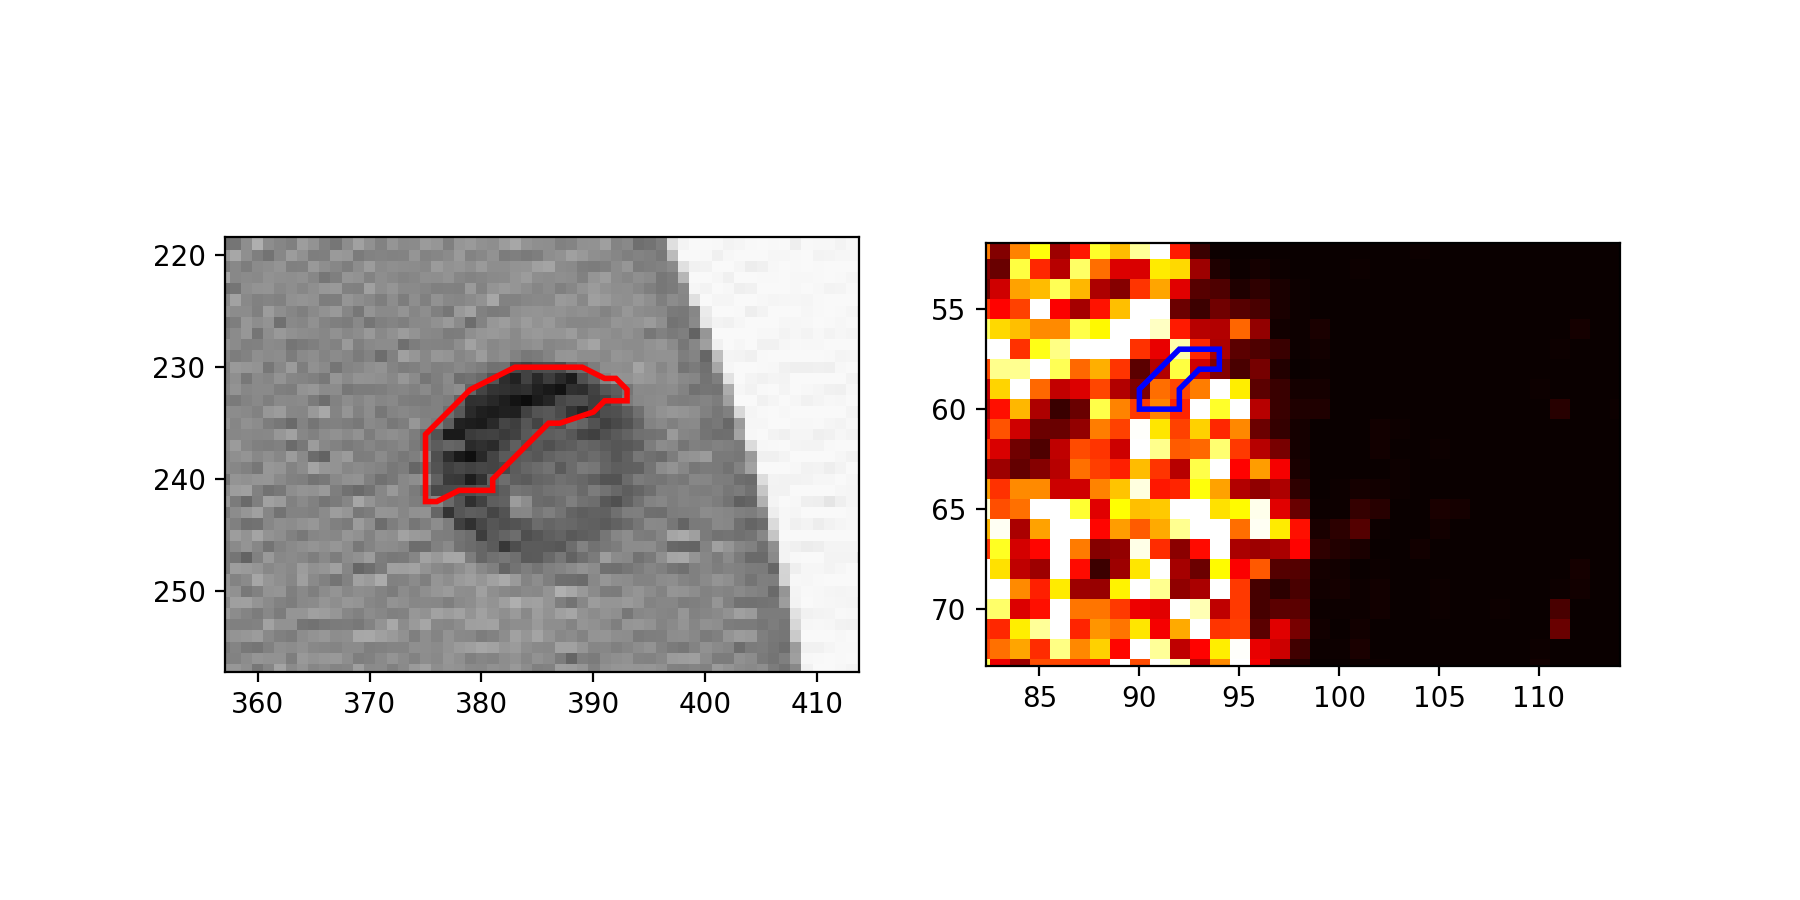

In [57]:
# DISPLAY STRUCTURE ON CT AND SPECT IMAGES TO VISUALLY CHECK
# THAT EVERYTHING'S ALL RIGHT (2D EVALUATION ONLY)

# get the list of points for the structure on the slice of interest:
c_data = m_struct.ROIContourSequence[m_ROInb].ContourSequence[m_sliceNb]


# Reads the list of points of the structure file on this slice of interest:
pointList = getPointList(c_data, dispNbPoints = True)


# Initialization of the Matplotlib figure:
CTgrid_size = (m_CTsizeX, m_CTsizeY)
SPECTgrid_size = (m_SPECTsizeX, m_SPECTsizeY)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4.5))

ax1.set_xlim(-0.5, m_CTsizeX+0.5)
ax1.set_ylim(m_CTsizeY+0.5, -0.5)

ax2.set_xlim(-0.5, m_SPECTsizeX+0.5)
ax2.set_ylim(m_SPECTsizeY+0.5, -0.5)


# Displays the CT image
imgID = c_data.ContourImageSequence[0].ReferencedSOPInstanceUID
CTimg = dicom.read_file(m_CTdict[imgID])
CTzOrigin = CTimg.ImagePositionPatient[2]
CTpixArray = CTimg.pixel_array
ax1.imshow(CTpixArray, cmap="Greys", interpolation="nearest", 
           vmin = m_CTvmin, vmax = m_CTvmax)


# Displays the SPECT image
CorrSPECTSlice = int((m_SPECTzOrigin-CTzOrigin) / m_SPECTzSpacing)
minv = np.amin(m_SPECTarray[CorrSPECTSlice,:,:])
maxv = np.amax(m_SPECTarray[CorrSPECTSlice,:,:])
ax2.imshow(m_SPECTarray[CorrSPECTSlice,:,:], cmap="hot", interpolation="nearest", 
           vmin = m_SPECTvmin, vmax = minv + m_SPECTvmax*(maxv-minv))


# Displays the CT contour:
cc1 = coordConverter(m_CTxOrigin, m_CTyOrigin, m_CTxSpacing, m_CTySpacing, m_CTsizeX, m_CTsizeY)
CT_pointList = cc1.converStructList(pointList)

polygoneCT = plt.Polygon(CT_pointList, fill=False, color = "red", linewidth=2)
ax1.add_patch(polygoneCT)


# Displays the SPECT contour:
cc2 = coordConverter(m_SPECTxOrigin, m_SPECTyOrigin, m_SPECTxSpacing, m_SPECTySpacing, m_SPECTsizeX, m_SPECTsizeY)
SPECT_pointList = cc2.converStructList(pointList)

polygoneSPECT = plt.Polygon(SPECT_pointList, fill=False, color = "blue", linewidth=2)
ax2.add_patch(polygoneSPECT)



Nb of points in the structure on that slice: 108
rESULTS:
 -> Selected slice 56
 -> ROI volume: 1983.6 mm3
 -> Total nb of counts: 51835
 -> min nb of counts in a voxel: 526
 -> max nb of counts in a voxel: 3347
 -> Mean nb of counts: 2253.7




<IPython.core.display.Javascript object>


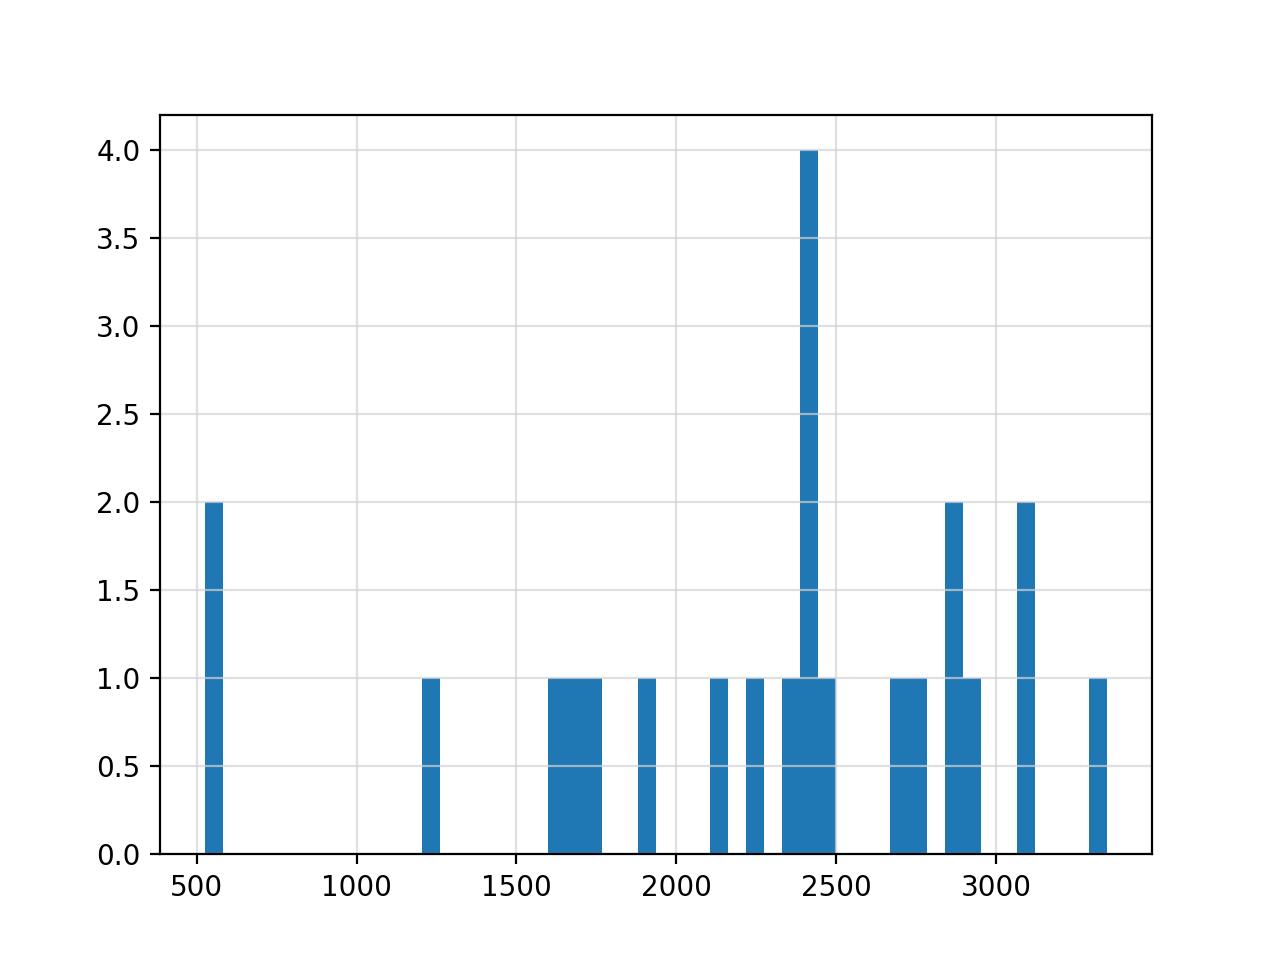



(execution time: 0.0779719352722168 s)


In [50]:
# NB OF COUNTS IN STRUCTURE CALCULATION (2D version):

# Calcul du temps d'execution:
time1 = time.time()


#Gets the point list of the structure:
c_data = m_struct.ROIContourSequence[m_ROInb].ContourSequence[m_sliceNb]
pointList = getPointList(c_data, dispNbPoints = True)


# Converts the point list in the SPECT ordinates:
cc = coordConverter(m_SPECTxOrigin, m_SPECTyOrigin, m_SPECTxSpacing, m_SPECTySpacing, m_SPECTsizeX, m_SPECTsizeY)
SPECT_pointList = cc.converStructList(pointList)

SPECTpath_contour = matplotlib.path.Path(SPECT_pointList)


# Gets the corresponding SPECT slice:
imgID = c_data.ContourImageSequence[0].ReferencedSOPInstanceUID
CTimg = dicom.read_file(m_CTdict[imgID])
CTzOrigin = CTimg.ImagePositionPatient[2]
corrSPECTSlice = int((m_SPECTzOrigin-CTzOrigin) / m_SPECTzSpacing)



volPixel = m_SPECTxSpacing * m_SPECTySpacing * m_SPECTzSpacing
volROI = 0
nbCountsInROI = 0
nbPix = 0
pixValues = []
for i in range(m_SPECTsizeX):
    for j in range(m_SPECTsizeY):
        if SPECTpath_contour.contains_point((i,j)):
            volROI += volPixel
            nbCountsInROI += m_SPECTarray[corrSPECTSlice,j,i]
            pixValues.append(m_SPECTarray[corrSPECTSlice,j,i])
            nbPix += 1

time2 = time.time()

print('rESULTS:')
print(' -> Selected slice', corrSPECTSlice)
print(' -> ROI volume:', round(volROI,1), 'mm3')            
print(' -> Total nb of counts:', nbCountsInROI)
print(' -> min nb of counts in a voxel:', np.min(pixValues))
print(' -> max nb of counts in a voxel:', np.max(pixValues))
print(' -> Mean nb of counts:', round(nbCountsInROI/nbPix,2))
print('\n')

fig, ax = plt.subplots()
ax.hist(pixValues, 50)
ax.grid(color='lightgray', alpha=0.7)

print('\n\n(execution time:', time2-time1, 's)')


rESULTS:
 -> Selected ROI: 2
 -> ROI volume: 23544.3 mm3
 -> min nb of counts in a voxel: 46
 -> max nb of counts in a voxel: 3612
 -> Total nb of counts: 480295
 -> Mean nb of counts in a pixel: 1759.32




<IPython.core.display.Javascript object>


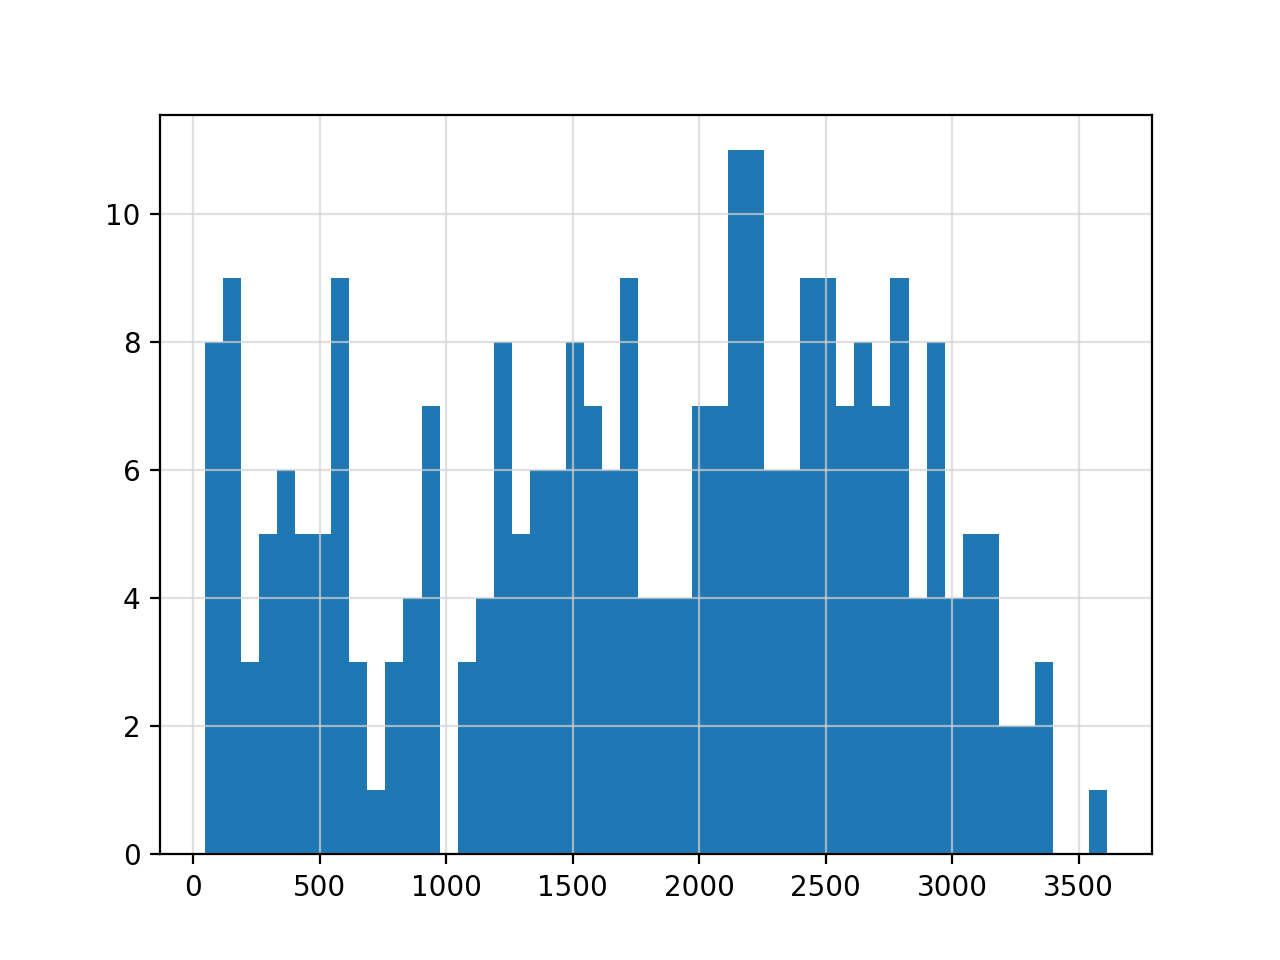



(execution time: 0.826462984085083 s)


In [53]:
# NB OF COUNTS IN STRUCTURE CALCULATION (3D version):


# Calcul du temps d'execution:
time1 = time.time()

# Variables initialization:
volPixel = m_SPECTxSpacing * m_SPECTySpacing * m_SPECTzSpacing
volROI = 0
nbCountsInROI = 0
nbPix = 0
pixValues = []

# Converter: contour point list in the SPECT coordinates
ccSPECT = coordConverter(m_SPECTxOrigin, m_SPECTyOrigin, m_SPECTxSpacing, 
                         m_SPECTySpacing, m_SPECTsizeX, m_SPECTsizeY)


# Gets the structure on first slice:
cd = m_struct.ROIContourSequence[m_ROInb].ContourSequence[0]

# Finds the corresponding z slice in the SPECT image:
imgID = cd.ContourImageSequence[0].ReferencedSOPInstanceUID
CTimg = dicom.read_file(m_CTdict[imgID])
posz = int((m_SPECTzOrigin-CTimg.ImagePositionPatient[2]) / m_SPECTzSpacing)

# Gets the points list and converts it the pixel nb in SPECT img:
pl = getPointList(cd)
SPECTpath_contour = matplotlib.path.Path(ccSPECT.converStructList(pl))

# Gets the statistics from the first slice:
for i in range(m_SPECTsizeX):
    for j in range(m_SPECTsizeY):
        if SPECTpath_contour.contains_point((i,j)):
            volROI += volPixel
            nbCountsInROI += m_SPECTarray[posz,j,i]
            pixValues.append(m_SPECTarray[posz,j,i])
            nbPix += 1


# Gets the statistics for the other slices:
nbslices = len(m_struct.ROIContourSequence[m_ROInb].ContourSequence)

for s in range(1, nbslices):
    cd = m_struct.ROIContourSequence[m_ROInb].ContourSequence[s]
    imgID = cd.ContourImageSequence[0].ReferencedSOPInstanceUID
    CTimg = dicom.read_file(m_CTdict[imgID])
    z = int((m_SPECTzOrigin-CTimg.ImagePositionPatient[2]) / m_SPECTzSpacing)
    if z != posz:
        posz = z
        pl = getPointList(cd)
        SPECTpath_contour = matplotlib.path.Path(ccSPECT.converStructList(pl))
        for i in range(m_SPECTsizeX):
            for j in range(m_SPECTsizeY):
                if SPECTpath_contour.contains_point((i,j)):
                    volROI += volPixel
                    nbCountsInROI += m_SPECTarray[posz,j,i]
                    pixValues.append(m_SPECTarray[posz,j,i])
                    nbPix += 1


time2 = time.time()
print('rESULTS:')
print(' -> Selected ROI:', m_ROInb)
print(' -> ROI volume:', round(volROI,1), 'mm3')            
print(' -> min nb of counts in a voxel:', np.min(pixValues))
print(' -> max nb of counts in a voxel:', np.max(pixValues))
print(' -> Total nb of counts:', nbCountsInROI)
print(' -> Mean nb of counts in a pixel:', round(nbCountsInROI/nbPix,2))
print('\n')

fig, ax = plt.subplots()
ax.hist(pixValues, 50)
ax.grid(color='lightgray', alpha=0.7)

print('\n\n(execution time:', time2-time1, 's)')


In [ ]:
N=0
pc=np.zeros((128,128,128))
for k in range (0,128):
    for i in range(0,128):
        for j in range(0,128):
             if mm[k,i,j]>0 :
                  pc[k,i,j]=p[k,i,j]
                  N=N+1
                    
v_f=(N*v_pixel) *10**(-3)                
print('le volume est de=',v_f  )                 
cp=np.sum(pc)
hour=int(img.AcquisitionTime[0:2])-14
min=int(img.AcquisitionTime[2:4])-59
t_s1=(23+hour)*60+min+10        #temps de comencent d'acqusition detecteur1  (min)
t_aq=int(img.RotationInformationSequence[0].ActualFrameDuration)*0.5/10**3         #duré d'acqusition (min)
t_p=792     #periode physique de 123-I (min)
#----------------------------------------------------------------------------------
A_inj_s1 =0.001093*16+(v_f+(-16))*0.000298   # l'activité de la suringue pliene (mCi)
t_s11=1       #temps de mesure  l'activité de la suringue pliene (min)
A_ss1=0   # l'activité de la suringue vide (mCi)
t_ss1=0       #temps de mesure  l'activité de la suringue vide (min)

A_ss1=(A_ss1 * exp((log(2)*t_ss1)/t_p))
A_inj_s1=(A_inj_s1 * exp((log(2)*t_s11)/t_p))
#correction de l'activité exact injecté  .
A_s1=A_inj_s1-A_ss1
#----------------------------------------------------------------------------------
#----------------------------------------------------------------------------------
A_inj_s2 =0.001093*8 +(v_f+(-8))*0.000298   # l'activité de la suringue pliene (mCi)
t_s2=1       #temps de mesure  l'activité de la suringue pliene (min)
A_ss2=0   # l'activité de la suringue vide (mCi)
t_ss2=0       #temps de mesure  l'activité de la suringue vide (min)

A_ss2=(A_ss2 * exp((log(2)*t_ss2)/t_p))
A_inj_s2=(A_inj_s2 * exp((log(2)*t_s2)/t_p))
#correction de l'activité exact injecté  .
A_s2=A_inj_s2-A_ss2
#----------------------------------------------------------------------------------
A_inj_fond =2.04   # l'activité de la suringue pliene (mCi)
t_fond=1      #temps de mesure  l'activité de la suringue pliene (min)
A_sfond=0  # l'activité de la suringue vide (mCi)
t_sfond=4      #temps de mesure  l'activité de la suringue vide (min)

A_sfond=(A_sfond * exp((log(2)*t_sfond)/t_p))
A_inj_fond=(A_inj_fond * exp((log(2)*t_fond)/t_p))
#correction de l'activité exact injecté  .
A_fond=A_inj_fond-A_sfond
#----------------------------------------------------------------------------------


#----------------------------------------------------------------------------------






#A_total=A_pd+A_lf+A_lc+A_foie+A_fond+A_pg
A_total=A_fond
# l'activité au moment de commencement d'acquisition  .

# l'activité au moment de commencement d'acquisition  .
A_01=A_total * exp((-log(2)*t_s1)/t_p)


# l'activité moyenne entre le debut et la fin d'acquisition mCi .


# nombre de coups par seconde    
cps=cp/(t_aq*2*60)
# l'activité moyenne entre le debut et la fin d'acquisition (MBq)  .
A_m1=(A_01 *37*(t_p/log(2))* (1-exp(-log(2)*t_aq/t_p)))/t_aq

A_mesuré=cps/62.5
print('activité réelle =',A_m1)
print('activité mesuré',A_mesuré)
v=abs(A_mesuré-A_m1)*100/A_m1
print('variation relative',v,'%')